In [1]:
# this code is written by Changyi Yang used for DS Discovery program

import torch.nn as nn
import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sklearn 
from sklearn.model_selection import GridSearchCV

import pandas as pd

In [2]:
torch. __version__

'1.13.1'

In [3]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)
# %cd /content/drive/Shareddrives/PebbleReactorProject/Data

In [4]:
# define the dataset classes
from sklearn.preprocessing import StandardScaler, MinMaxScaler


class ReactorData(Dataset):
    def __init__(self,file_name, sequence_length, start_percent = 0, end_percent = 1):
        data = pd.read_csv(file_name, skiprows=[0]) # skip the first line
        
        length = data.shape[0]
        data = data[ int(length * start_percent)  : int(length * end_percent)]
        
        # print(data.shape)
        
        
        self.labels = data.iloc[:, -1:]
        self.data = data.iloc[:, 1:-1] # skip the first time column
        
        mm = MinMaxScaler()
        ss = StandardScaler()


        self.data = ss.fit_transform(self.data)
        self.labels = mm.fit_transform(self.labels) 
        
        self.sequence_length = sequence_length
        
    def __len__(self):
        return len(self.labels)//self.sequence_length
    
    def __getitem__(self,idx):
        idx = idx * self.sequence_length
        
        return (torch.tensor(self.data[idx : idx+ self.sequence_length])).double(), \
    (torch.tensor(self.labels[idx : idx+ self.sequence_length])).double()

        

In [5]:
# load the data
training_data = ReactorData('binnedpebbles.csv', sequence_length= 10, start_percent= 0, end_percent= 0.75)
testing_data = ReactorData('binnedpebbles.csv', sequence_length= 10, start_percent= 0.75, end_percent= 1)


In [6]:
# print(training_data[0][1])
# print(training_data[0][0].shape)
# print(training_data[0][1].shape)

# print(len(training_data[0]))
# print(len(training_data))

In [7]:
# define the neural nets
class SimpleLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, lstm_nums_layer, dropout):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        
        
        self.LSTM = nn.LSTM(input_dim, hidden_dim, lstm_nums_layer, batch_first = True)
        self.dropout = nn.Dropout(dropout)
        
        self.hidden_to_output = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, input):
        # print(input.shape)
        
        hidden_state, _ = self.LSTM(input)
        
        # print(hidden_state.shape)
        output = self.dropout(hidden_state)
        output = self.hidden_to_output(output)
        
        
        return output
    
    


In [23]:
# train the model

input_dim = training_data[0][0].shape[1]
output_dim = training_data[0][1].shape[1]


# print(output_dim)

# some adjustable hyper-parameters
hidden_dim = 64
num_hidden_layers = 2
batch_size = 32
learning_rate = 1e-3
weight_decay = 1e-5
epoch_num = 128
dropout = 0.2


def train(hidden_dim, num_hidden_layers, batch_size, learning_rate, weight_decay, epoch_num, dropout):
    model = SimpleLSTM(input_dim, hidden_dim, output_dim, num_hidden_layers, dropout)
    model = model.double()

    train_dataloader = DataLoader(training_data, batch_size = batch_size)


    # the chosn loss function and optimizer
    loss_fn = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr = learning_rate, weight_decay= weight_decay)

    for epoch in range(epoch_num):
    
        for batch, (X, y) in enumerate(train_dataloader):
            model.zero_grad()
        
            pred = model(X)
        
            # print(X.shape)
            # print(y.shape)
        
            loss = loss_fn(pred, y)
        
            # backpropagation
        
            loss.backward()
            optimizer.step()
        
            loss = loss.item()
        
        #if epoch % 5 == 0:
         #   print("The loss is {} in epoch {}".format(loss ,epoch))
    return model
            

#print(f"The training is ended, the final loss is {loss}.")
print("Bye")

Bye


In [24]:
def test(model, testing_data):
    X_test = (torch.tensor(testing_data.data)).double()
    y_test = (torch.tensor(testing_data.labels)).double()

    y_pred = model(X_test)
    loss = nn.MSELoss()
    print(f"The test loss is {loss(y_pred, y_test).item()}")
    return loss(y_pred, y_test).item()

In [25]:
trained_model = train(hidden_dim, num_hidden_layers, batch_size, learning_rate, weight_decay, epoch_num, dropout)
test(trained_model, testing_data)

The test loss is 0.07326436146294438


0.07326436146294438

In [26]:
best_loss = 1
best_params = [0] * 5

for i in range(5, 8):
    hidden_dim = 2**i
    for k in range(-1, 2):
        dropout = (2**k)*0.1
        for l in range(2, 6):
            learning_rate = 10**(-l)
            for m in range(2, 6):
                weight_decay = 10**(-l)
                for n in range(2, 6):
                    batch_size = 2**n
                    trained_model = train(hidden_dim, 2, batch_size, learning_rate, weight_decay, 100, dropout)
                    loss = test(trained_model, testing_data)
                    if loss < best_loss:
                        best_loss = loss
                        best_params[0] = hidden_dim
                        best_params[1] = dropout
                        best_params[2] = learning_rate
                        best_params[3] = weight_decay
                        best_params[4] = batch_size


                        
                        
print("iterations completed")                        
print(best_params)
print(best_loss)

The test loss is 0.07317486260703346
The test loss is 0.08297232413510487
The test loss is 0.08585560642679106
The test loss is 0.07111527045596999
The test loss is 0.05436037930538238
The test loss is 0.10827166431310856
The test loss is 0.06650005659207926
The test loss is 0.06616741856172022
The test loss is 0.06140419963573863
The test loss is 0.09466111297560333
The test loss is 0.07303246210712515
The test loss is 0.0692335280782803
The test loss is 0.06896451085449612
The test loss is 0.08171885234220677
The test loss is 0.07480832478771385
The test loss is 0.07190326983958406
The test loss is 0.07935634082160713
The test loss is 0.08324922958032813
The test loss is 0.07312073070717105
The test loss is 0.07103625591816248
The test loss is 0.08664805347201836
The test loss is 0.0755959610350594
The test loss is 0.08763955720637477
The test loss is 0.08000064605264179
The test loss is 0.09586079722971609
The test loss is 0.0797962397937107
The test loss is 0.0898576752101071
The t

The test loss is 0.11159008737195794
The test loss is 0.08621681155364716
The test loss is 0.08909378555329285
The test loss is 0.10211829241463521
The test loss is 0.09952144943302639
The test loss is 0.08395365966078108
The test loss is 0.08970187607973219
The test loss is 0.11914098319599574
The test loss is 0.08623516850387428
The test loss is 0.10453734146840775
The test loss is 0.12840374121899167
The test loss is 0.11588835792388834
The test loss is 0.12535667336090323
The test loss is 0.10657379985071211
The test loss is 0.10538260121461285
The test loss is 0.0734792698800208
The test loss is 0.340457887691484
The test loss is 0.27053387600848644
The test loss is 0.5601462038593995
The test loss is 0.6924071348341374
The test loss is 0.4386615671284866
The test loss is 0.2941862583631171
The test loss is 0.5239897151356007
The test loss is 0.5650647345567923
The test loss is 0.44289326122811795
The test loss is 0.49256682433244003
The test loss is 0.43719080552107464
The test l

The test loss is 0.06091666335467239
The test loss is 0.07851795149474396
The test loss is 0.07754138948169251
The test loss is 0.07387875651692967
The test loss is 0.09101759222797955
The test loss is 0.07662292750071208
The test loss is 0.08974962514227162
The test loss is 0.07209755213953369
The test loss is 0.0810782471880383
The test loss is 0.09064971355880343
The test loss is 0.07840536859953531
The test loss is 0.07553014479149506
The test loss is 0.05768202052002784
The test loss is 0.07029478569596001
The test loss is 0.0824113394252904
The test loss is 0.0756842039180386
The test loss is 0.09285762543136412
The test loss is 0.08391149673827543
The test loss is 0.08732064565379488
The test loss is 0.08855208374264181
The test loss is 0.08360983242945638
The test loss is 0.08445132635240384
The test loss is 0.08309904500880964
The test loss is 0.08431188246994005
The test loss is 0.0766958569003922
The test loss is 0.08689334390394256
The test loss is 0.08040702517599303
The t

In [30]:

best_model = train(128, 2, 4, 0.01, 0.01, 100, 0.05)
test(best_model, testing_data)

The test loss is 0.05618117631236936


0.05618117631236936

In [ ]:
#param_grid = {'hidden_dim': [32, 64, 128],  
              #'num_hidden_layers': [1, 2, 3], 
              #'batch_size':[5, 10, 15, 20, 25, 30],
              #'learning_rate': [1e-2, 1e-3, 1e-4, 1e-5],
              #'weight_decay': [1e-2, 1e-3, 1e-4, 1e-5],
              #'epoch_num': [100, 150, 200]
              #'dropout': [0.05, 0.1, 0.2, 0.3]}  
#gs_lstm = GridSearchCV(train,
                      #param_grid=param_grid,
                      #scoring=test,
                      #cv=5)

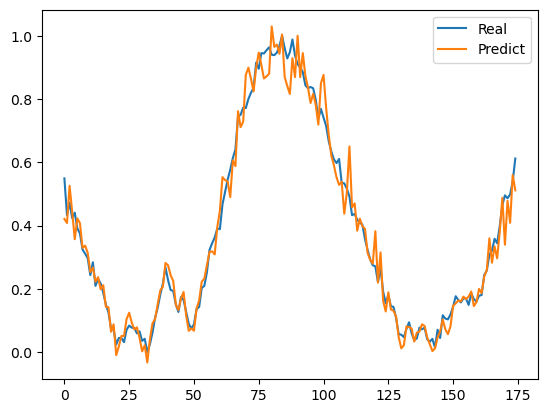

In [37]:
# visualize the training output

import matplotlib.pyplot as plt


X_train = (torch.tensor(training_data.data)).double()
y_train = (torch.tensor(training_data.labels)).double()


plt.figure()
plt.plot(y_train, label = "Real")     
plt.plot(model(X_train).detach().numpy(), label = "Predict")
plt.legend()


0.05476683618164265


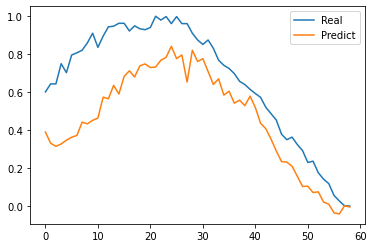

In [31]:
# visualize the test output

import matplotlib.pyplot as plt


X_test = (torch.tensor(testing_data.data)).double()
y_test = (torch.tensor(testing_data.labels)).double()

y_pred = best_model(X_test)

loss = nn.MSELoss()
print(loss(y_pred, y_test).item())

plt.figure()
plt.plot(y_test, label = "Real")     
plt.plot(y_pred.detach().numpy(), label = "Predict")
plt.legend()